# Extra Trees Classifier

# Import necessary libraries

In [79]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
import joblib

# # Load the dataset and set display options to show all rows and print first few rows


In [80]:
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the first few rows of the DataFrame
print(df.head())

  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

# List the significant features, and separate features and the target variable


In [81]:
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction']).ravel()  # Ensure y is a 1D array


# Define the hyperparameter search space for Extra Trees


In [82]:
search_space_extra_trees = {
    'n_estimators': (10, 20, 30, 40, 100, 120, 1000), # number of trees in the foreset
    'max_features': (1, X.shape[1]), # max number of features considered for splitting a node
    'min_samples_split': (2, 20), # min number of data points placed in a node before the node is split
    'min_samples_leaf': (1, 20), # min number of data points allowed in a leaf node
    'bootstrap': [True, False], # method for sampling data points (with or without replacement)
    'criterion': ['gini', 'entropy'] # quality of split
}

The dictionary `search_space_extra_trees` defines the hyperparameter search space for an `ExtraTreesClassifier` in a machine learning model. Each key in the dictionary represents a hyperparameter, and the corresponding value is the range or set of values that will be explored during hyperparameter tuning. Here's a brief explanation of each hyperparameter:

- **`n_estimators`**: The number of trees in the forest. The range (10, 1000) means that the search will consider values from 10 to 1000.
- **`max_features`**: The number of features to consider when looking for the best split. The range (1, X.shape[1]) means that the search will consider values from 1 to the total number of features in the dataset.
- **`min_samples_split`**: The minimum number of samples required to split an internal node. The range (2, 20) means that the search will consider values from 2 to 20.
- **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node. The range (1, 20) means that the search will consider values from 1 to 20.
- **`bootstrap`**: Whether bootstrap samples are used when building trees. The search will consider both `True` and `False`.
- **`criterion`**: The function to measure the quality of a split. The search will consider both 'gini' and 'entropy'.

This search space will be used in hyperparameter tuning methods like GridSearchCV or RandomizedSearchCV to find the best combination of hyperparameters for the `ExtraTreesClassifier`.

# Initialize and perform Bayesian optimization for Extra Trees


In [83]:
extra_trees = ExtraTreesClassifier()
opt_extra_trees = BayesSearchCV(extra_trees, search_space_extra_trees, n_iter=16, cv=StratifiedKFold(n_splits=5), n_jobs=-1) # n_iter is the number of parameter settings that are sampled, stratified k-fold is used for cross-validation and n_jobs is the number of jobs to run in parallel
opt_extra_trees.fit(X, y)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=ExtraTreesClassifier(), n_iter=16, n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy'],
                             'max_features': (1, 3),
                             'min_samples_leaf': (1, 20),
                             'min_samples_split': (2, 20),
                             'n_estimators': (10, 20, 30, 40, 100, 120, 1000)})

# Print the best hyperparameters found by Bayesian optimization

In [84]:
print(f"Best hyperparameters for Extra Trees: {opt_extra_trees.best_params_}")

Best hyperparameters for Extra Trees: OrderedDict({'bootstrap': False, 'criterion': 'gini', 'max_features': 1, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100})


# Evaluate the Extra Trees model


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opt_extra_trees.best_estimator_.fit(X_train, y_train)
y_test_pred = opt_extra_trees.best_estimator_.predict(X_test)
y_test_prob = opt_extra_trees.best_estimator_.predict_proba(X_test)

# Calculate AUC and accuracy


In [86]:
final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
final_acc = accuracy_score(y_test, y_test_pred)

print(f"Final Evaluation on Test Set for Extra Trees Model:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}")


Final Evaluation on Test Set for Extra Trees Model:
AUC: 0.6155, Accuracy: 0.4452


# Save results to a CSV file


In [87]:
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_test_pred,
    'Probability': y_test_prob.max(axis=1)
})
results_df.to_csv('extra_trees_model_results.csv', index=False)


# Save the best Extra Trees model to a file


In [88]:
joblib.dump(opt_extra_trees.best_estimator_, 'extra_trees_model.pkl')


['extra_trees_model.pkl']

# Plot the extra trees using graphviz


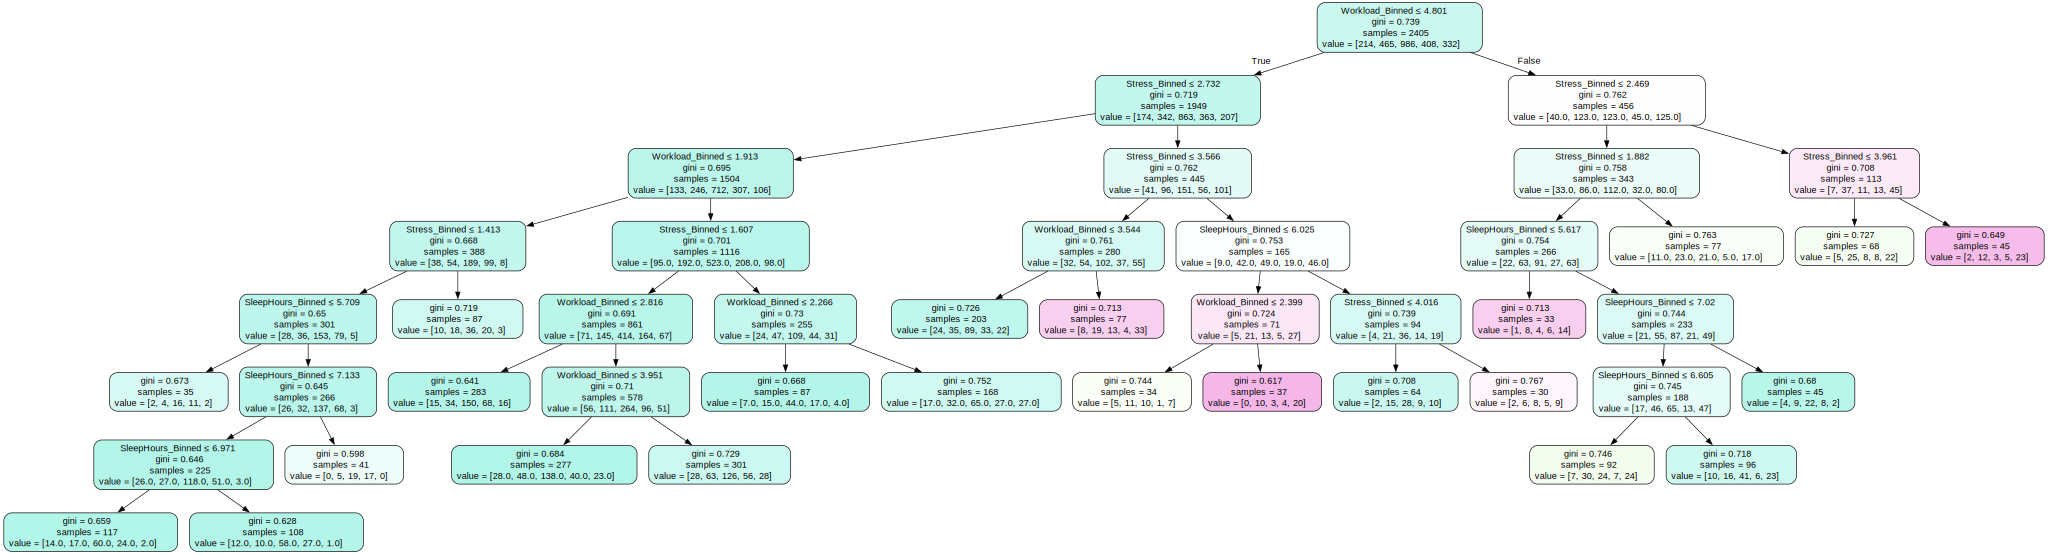

In [89]:



# Function to export and visualize a tree from the Extra Trees model
def visualize_tree(estimator, feature_names, tree_index):

    # Export the tree to DOT format
    dot_data = export_graphviz(
        estimator.estimators_[tree_index],
        out_file=None,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    # Render the tree using Graphviz
    graph = graphviz.Source(dot_data)
    return graph

# Visualize the first tree in the Extra Trees model
graph = visualize_tree(opt_extra_trees.best_estimator_, significant_features, 0)
display(graph)  # Display the tree visualization inline

# Plot ROC curve for the Extra Trees model
